In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import sqrt 
import matplotlib.dates as mdates
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from scipy import stats
import datetime
import calendar
import seaborn as sns

In [2]:
# import data #

# follower data
df_ad_f = pd.read_csv("data/exp2-stbunstb/CPU_follower_ad.csv", sep=" ")
df_nad_f = pd.read_csv("data/exp2-stbunstb/CPU_follower_nad.csv", sep=" ")

# leader data
df_ad_l = pd.read_csv("data/exp2-stbunstb/CPU_leader_ad.csv", sep=" ")
df_nad_l = pd.read_csv("data/exp2-stbunstb/CPU_leader_nad.csv", sep=" ")

# metrics generator data
df_real_ad = pd.read_csv("data/exp2-stbunstb/CPU_real_ad.csv", sep=" ")
df_real_nad = pd.read_csv("data/exp2-stbunstb/CPU_real_nad.csv", sep=" ")

In [3]:
# cast type

# follower
df_ad_f["free_cpu"] = df_ad_f["free_cpu"].astype(float)
df_ad_f["time_report"] = df_ad_f["time_report"].astype(int)
df_ad_f["timestamp"] = pd.to_datetime(df_ad_f["timestamp"], unit='s')

df_nad_f["free_cpu"] = df_nad_f["free_cpu"].astype(float)
df_nad_f["time_report"] = df_nad_f["time_report"].astype(int)
df_nad_f["timestamp"] = pd.to_datetime(df_nad_f["timestamp"], unit='s')

# leader
df_ad_l["mean_free_cpu"] = df_ad_l["mean_free_cpu"].astype(float)
df_ad_l["timestamp"] = pd.to_datetime(df_ad_l["timestamp"], unit='s')

df_nad_l["mean_free_cpu"] = df_nad_l["mean_free_cpu"].astype(float)
df_nad_l["timestamp"] = pd.to_datetime(df_nad_l["timestamp"], unit='s')

# metrics generator
df_real_ad["free_cpu"] = df_real_ad["free_cpu"].astype(float)
df_real_ad["timestamp"] = pd.to_datetime(df_real_ad["timestamp"], unit='s')

df_real_nad["free_cpu"] = df_real_nad["free_cpu"].astype(float)
df_real_nad["timestamp"] = pd.to_datetime(df_real_nad["timestamp"], unit='s')

In [4]:
# limit to 10 minutes run

limit = 1200

# ad
# follower
time_start_ad_f = df_ad_f["timestamp"][1]
df_ad_f = df_ad_f[df_ad_f["timestamp"] < time_start_ad_f + pd.to_timedelta(limit, unit='s')]

# leader
time_start_ad_l = df_ad_l["timestamp"][0]
df_ad_l = df_ad_l[df_ad_l["timestamp"] < time_start_ad_l + pd.to_timedelta(limit, unit='s')]

# metrics generator
time_start_real_ad = df_real_ad["timestamp"][0]
df_real_ad = df_real_ad[df_real_ad["timestamp"] < time_start_real_ad + pd.to_timedelta(limit, unit='s')]


# nad
# follower
time_start_nad_f = df_nad_f["timestamp"][1]
df_nad_f = df_nad_f[df_nad_f["timestamp"] < time_start_nad_f + pd.to_timedelta(limit, unit='s')]

# leader
time_start_nad_l = df_nad_l["timestamp"][0]
df_nad_l = df_nad_l[df_nad_l["timestamp"] < time_start_nad_l + pd.to_timedelta(limit, unit='s')]

# metrics generator
time_start_real_nad = df_real_nad["timestamp"][0]
df_real_nad = df_real_nad[df_real_nad["timestamp"] < time_start_real_nad + pd.to_timedelta(limit, unit='s')]

In [5]:
# metrics generator leader

# ad
df_real_ad_l = pd.DataFrame(columns=["mean_free_cpu", "timestamp"])

free_cpu = [0.0]
for idx, row in df_real_ad.iterrows():
    free_cpu.append(row["free_cpu"])

mean_free_cpu = []
w_min = 0
for i in range(1, len(free_cpu)+1):
    if(i > 20):
        w_min += 1
    l = free_cpu[w_min:i]
    mean_free_cpu.append(sum(l)/len(l))
mean_free_cpu = mean_free_cpu[1:]

df_real_ad_l["timestamp"] = df_real_ad["timestamp"]
df_real_ad_l["mean_free_cpu"] = mean_free_cpu

# nad
df_real_nad_l = pd.DataFrame(columns=["mean_free_cpu", "timestamp"])

free_cpu = [0.0]
for idx, row in df_real_nad.iterrows():
    free_cpu.append(row["free_cpu"])

mean_free_cpu = []
w_min = 0
for i in range(1, len(free_cpu)+1):
    if(i > 20):
        w_min += 1
    l = free_cpu[w_min:i]
    mean_free_cpu.append(sum(l)/len(l))
mean_free_cpu = mean_free_cpu[1:]
    
df_real_nad_l["timestamp"] = df_real_nad["timestamp"]
df_real_nad_l["mean_free_cpu"] = mean_free_cpu

In [6]:
# new timestamps #

# ad
l = len(df_ad_f)
ad_f_timestamps = df_ad_f["timestamp"].to_list()
ad_f_cpu = df_ad_f["free_cpu"].to_list()
new_ts_ad_f = []
for i in range(l):
    ts = ad_f_timestamps[i]
    cpu = ad_f_cpu[i]
    if(ts > time_start_real_ad):
        while(((df_real_ad["timestamp"] == ts) & (df_real_ad["free_cpu"] == cpu)).any() == False):
            ts = ts - pd.to_timedelta(1, unit='s')
    new_ts_ad_f.append(ts)
df_ad_f["timestamp"] = new_ts_ad_f
df_ad_l["timestamp"] = new_ts_ad_f[1:]

# nad
l = len(df_nad_f)
nad_f_timestamps = df_nad_f["timestamp"].to_list()
nad_f_cpu = df_nad_f["free_cpu"].to_list()
new_ts_nad_f = []
for i in range(l):
    ts = nad_f_timestamps[i]
    cpu = nad_f_cpu[i]
    if(ts > time_start_real_nad):
        while(((df_real_nad["timestamp"] == ts) & (df_real_nad["free_cpu"] == cpu)).any() == False):
            ts = ts - pd.to_timedelta(1, unit='s')
    new_ts_nad_f.append(ts)
df_nad_f["timestamp"] = new_ts_nad_f
df_nad_l["timestamp"] = new_ts_nad_f[1:]

In [7]:
# cast datetime to unix timestamps #

df_ad_f["timestamp"] = df_ad_f["timestamp"].apply(lambda x: calendar.timegm(x.timetuple()))
df_ad_l["timestamp"] = df_ad_l["timestamp"].apply(lambda x: calendar.timegm(x.timetuple()))
df_real_ad["timestamp"] = df_real_ad["timestamp"].apply(lambda x: calendar.timegm(x.timetuple()))
df_real_ad_l["timestamp"] = df_real_ad_l["timestamp"].apply(lambda x: calendar.timegm(x.timetuple()))

df_nad_f["timestamp"] = df_nad_f["timestamp"].apply(lambda x: calendar.timegm(x.timetuple()))
df_nad_l["timestamp"] = df_nad_l["timestamp"].apply(lambda x: calendar.timegm(x.timetuple()))
df_real_nad["timestamp"] = df_real_nad["timestamp"].apply(lambda x: calendar.timegm(x.timetuple()))
df_real_nad_l["timestamp"] = df_real_nad_l["timestamp"].apply(lambda x: calendar.timegm(x.timetuple()))

In [8]:
# get interpolated data #

# ad_f
min_timestamp_ad_f = max(df_ad_f["timestamp"][0], df_real_ad["timestamp"][0])
max_timestamp_ad_f = min(df_ad_f["timestamp"][len(df_ad_f)-1], df_real_ad["timestamp"][len(df_real_ad)-1])

x_ad_f = df_ad_f["timestamp"].to_numpy()
y_ad_f = df_ad_f["free_cpu"].to_numpy() 

xs_ad_f = np.sort(x_ad_f)
ys_ad_f = np.array(y_ad_f)[np.argsort(x_ad_f)]

x0s_ad_f = []
timestamp = min_timestamp_ad_f
while(timestamp <= max_timestamp_ad_f):
    x0s_ad_f.append(timestamp)
    timestamp = timestamp + 1

y0s_ad_f = []
for x0 in x0s_ad_f:
    y0s_ad_f.append(np.interp(x0, xs_ad_f, ys_ad_f))

# real_ad
x_real_ad = df_real_ad["timestamp"].to_numpy()
y_real_ad = df_real_ad["free_cpu"].to_numpy() 

xs_real_ad = np.sort(x_real_ad)
ys_real_ad = np.array(y_real_ad)[np.argsort(x_real_ad)]
    
y0s_real_ad = []
for x0 in x0s_ad_f:
    y0s_real_ad.append(np.interp(x0, xs_real_ad, ys_real_ad))
    
    
# ad_l
min_timestamp_ad_l = max(df_ad_l["timestamp"][0], df_real_ad_l["timestamp"][0])
max_timestamp_ad_l = min(df_ad_l["timestamp"][len(df_ad_l)-1], df_real_ad_l["timestamp"][len(df_real_ad_l)-1])

x_ad_l = df_ad_l["timestamp"].to_numpy()
y_ad_l = df_ad_l["mean_free_cpu"].to_numpy() 

xs_ad_l = np.sort(x_ad_l)
ys_ad_l = np.array(y_ad_l)[np.argsort(x_ad_l)]

x0s_ad_l = []
timestamp = min_timestamp_ad_l
while(timestamp <= max_timestamp_ad_l):
    x0s_ad_l.append(timestamp)
    timestamp = timestamp + 1

y0s_ad_l = []
for x0 in x0s_ad_l:
    y0s_ad_l.append(np.interp(x0, xs_ad_l, ys_ad_l))
    
# ad_real_l
x_real_ad_l = df_real_ad_l["timestamp"].to_numpy()
y_real_ad_l = df_real_ad_l["mean_free_cpu"].to_numpy() 

xs_real_ad_l = np.sort(x_real_ad_l)
ys_real_ad_l = np.array(y_real_ad_l)[np.argsort(x_real_ad_l)]
    
y0s_real_ad_l = []
for x0 in x0s_ad_l:
    y0s_real_ad_l.append(np.interp(x0, xs_real_ad_l, ys_real_ad_l))

    
    
    
    
    
# nad

# nad_f
min_timestamp_nad_f = max(df_nad_f["timestamp"][0], df_real_nad["timestamp"][0])
max_timestamp_nad_f = min(df_nad_f["timestamp"][len(df_nad_f)-1], df_real_nad["timestamp"][len(df_real_nad)-1])

x_nad_f = df_nad_f["timestamp"].to_numpy()
y_nad_f = df_nad_f["free_cpu"].to_numpy() 

xs_nad_f = np.sort(x_nad_f)
ys_nad_f = np.array(y_nad_f)[np.argsort(x_nad_f)]

x0s_nad_f = []
timestamp = min_timestamp_nad_f
while(timestamp <= max_timestamp_nad_f):
    x0s_nad_f.append(timestamp)
    timestamp = timestamp + 1

y0s_nad_f = []
for x0 in x0s_nad_f:
    y0s_nad_f.append(np.interp(x0, xs_nad_f, ys_nad_f))

# real_nad
x_real_nad = df_real_nad["timestamp"].to_numpy()
y_real_nad = df_real_nad["free_cpu"].to_numpy() 

xs_real_nad = np.array(x_real_nad)
ys_real_nad = np.array(y_real_nad)[np.argsort(x_real_nad)]
    
y0s_real_nad = []
for x0 in x0s_nad_f:
    y0s_real_nad.append(np.interp(x0, xs_real_nad, ys_real_nad))
    
# nad_l
min_timestamp_nad_l = max(df_nad_l["timestamp"][0], df_real_nad_l["timestamp"][0])
max_timestamp_nad_l = min(df_nad_l["timestamp"][len(df_nad_l)-1], df_real_nad_l["timestamp"][len(df_real_nad_l)-1])

x_nad_l = df_nad_l["timestamp"].to_numpy()
y_nad_l = df_nad_l["mean_free_cpu"].to_numpy() 

xs_nad_l = np.sort(x_nad_l)
ys_nad_l = np.array(y_nad_l)[np.argsort(x_nad_l)]

x0s_nad_l = []
timestamp = min_timestamp_nad_l
while(timestamp <= max_timestamp_nad_l):
    x0s_nad_l.append(timestamp)
    timestamp = timestamp + 1

y0s_nad_l = []
for x0 in x0s_nad_l:
    y0s_nad_l.append(np.interp(x0, xs_nad_l, ys_nad_l))
    
# real_nad_l
x_real_nad_l = df_real_nad_l["timestamp"].to_numpy()
y_real_nad_l = df_real_nad_l["mean_free_cpu"].to_numpy() 

xs_real_nad_l = np.array(x_real_nad_l)
ys_real_nad_l = np.array(y_real_nad_l)[np.argsort(x_real_nad_l)]
    
y0s_real_nad_l = []
for x0 in x0s_nad_l:
    y0s_real_nad_l.append(np.interp(x0, xs_real_nad_l, ys_real_nad_l))

In [9]:
# timedelta

# ad_f
df_ad_f["timedelta"] = pd.to_datetime(pd.to_timedelta(pd.to_datetime(df_ad_f["timestamp"], unit='s') - pd.to_datetime(min_timestamp_ad_f, unit='s')).dt.seconds, unit='s')
df_real_ad["timedelta"] = pd.to_datetime(pd.to_timedelta(pd.to_datetime(df_real_ad["timestamp"], unit='s') - pd.to_datetime(min_timestamp_ad_f, unit='s')).dt.seconds, unit='s')

# ad_l
df_ad_l["timedelta"] = pd.to_datetime(pd.to_timedelta(pd.to_datetime(df_ad_l["timestamp"], unit='s') - pd.to_datetime(min_timestamp_ad_l, unit='s')).dt.seconds, unit='s')
df_real_ad_l["timedelta"] = pd.to_datetime(pd.to_timedelta(pd.to_datetime(df_real_ad_l["timestamp"], unit='s') - pd.to_datetime(min_timestamp_ad_l, unit='s')).dt.seconds, unit='s')

# nad_f
df_nad_f["timedelta"] = pd.to_datetime(pd.to_timedelta(pd.to_datetime(df_nad_f["timestamp"], unit='s') - pd.to_datetime(min_timestamp_nad_f, unit='s')).dt.seconds, unit='s')
df_real_nad["timedelta"] = pd.to_datetime(pd.to_timedelta(pd.to_datetime(df_real_nad["timestamp"], unit='s') - pd.to_datetime(min_timestamp_nad_f, unit='s')).dt.seconds, unit='s')

# nad_l
df_nad_l["timedelta"] = pd.to_datetime(pd.to_timedelta(pd.to_datetime(df_nad_l["timestamp"], unit='s') - pd.to_datetime(min_timestamp_nad_l, unit='s')).dt.seconds, unit='s')
df_real_nad_l["timedelta"] = pd.to_datetime(pd.to_timedelta(pd.to_datetime(df_real_nad_l["timestamp"], unit='s') - pd.to_datetime(min_timestamp_nad_l, unit='s')).dt.seconds, unit='s')

In [10]:
sns.set()
sns.set_style("whitegrid")

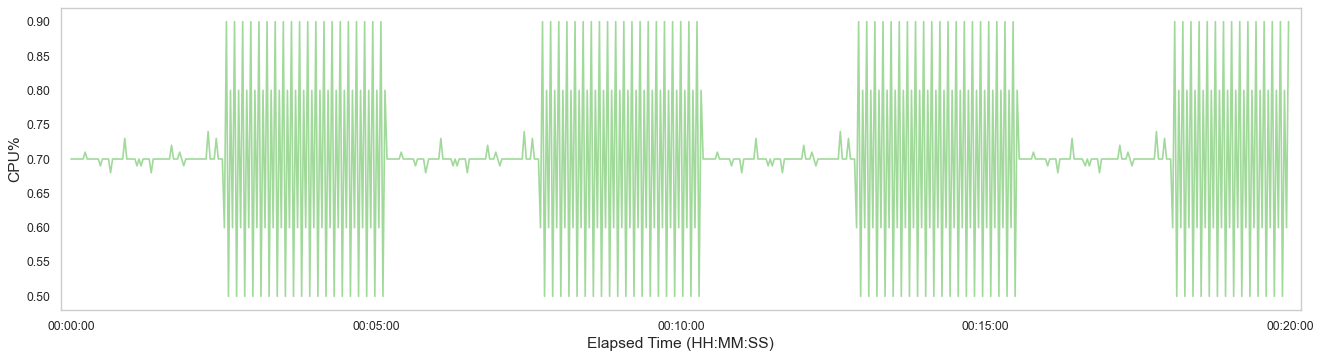

In [11]:
fig = plt.figure(figsize=(20, 5), dpi=80)

plt.plot('timedelta', 'free_cpu', data=df_real_ad, color='#a1d99b', zorder=5)
    
plt.xlabel("Elapsed Time (HH:MM:SS)", fontsize=14)
plt.ylabel("CPU%", fontsize=14)

plt.xlim(pd.to_datetime("1970-01-01 00:00:00")-pd.to_timedelta(10, unit='s'), pd.to_datetime("1970-01-01 00:20:00")+pd.to_timedelta(10, unit='s'))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(False)

plt.savefig("graphs/exp2-stbunstb/real.pdf",bbox_inches='tight')

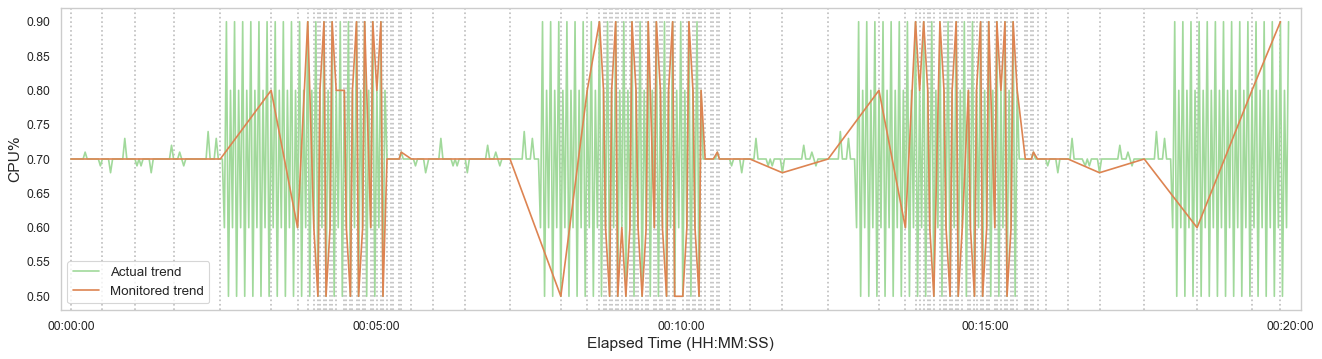

In [12]:
fig = plt.figure(figsize=(20, 5), dpi=80)

plt.plot('timedelta', 'free_cpu', data=df_real_ad, color='#a1d99b', zorder=5)
plt.plot('timedelta', 'free_cpu', data=df_ad_f[1:], color=sns.color_palette()[1], zorder=10)

plt.legend(["Actual trend", "Monitored trend"], loc='lower left', prop={'size': 12})

for idx, row in df_ad_f[1:].iterrows():
    plt.axvline(x=row["timedelta"], linestyle="dotted", color="#bdbdbd", zorder=2)
    
plt.xlabel("Elapsed Time (HH:MM:SS)", fontsize=14)
plt.ylabel("CPU%", fontsize=14)

plt.xlim(pd.to_datetime("1970-01-01 00:00:00")-pd.to_timedelta(10, unit='s'), pd.to_datetime("1970-01-01 00:20:00")+pd.to_timedelta(10, unit='s'))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(False)

plt.savefig("graphs/exp2-stbunstb/adp.pdf",bbox_inches='tight')

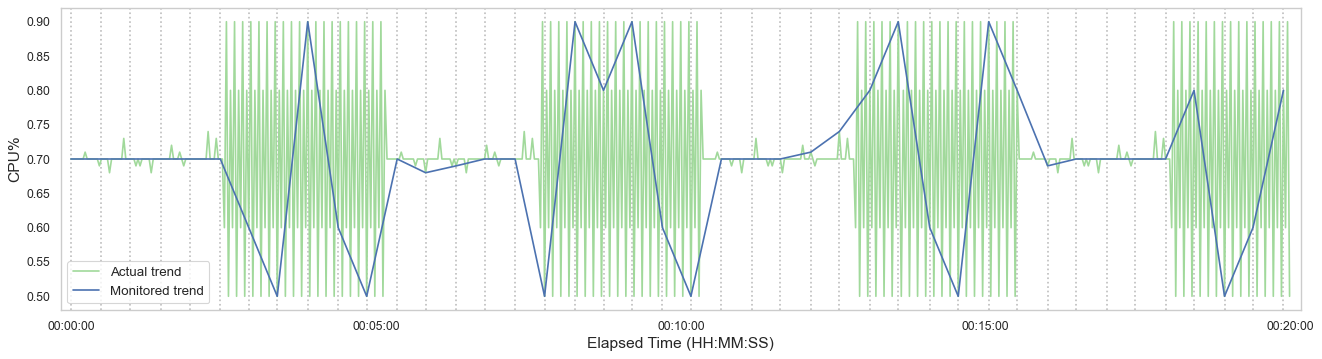

In [13]:
fig = plt.figure(figsize=(20, 5), dpi=80)

plt.plot('timedelta', 'free_cpu', data=df_real_nad, color='#a1d99b', zorder=5)
plt.plot('timedelta', 'free_cpu', data=df_nad_f[1:], color=sns.color_palette()[0], zorder=10)

plt.legend(["Actual trend", "Monitored trend"], loc='lower left', prop={'size': 12})

for idx, row in df_nad_f[1:].iterrows():
    plt.axvline(x=row["timedelta"], linestyle="dotted", color="#bdbdbd", zorder=2)
    
plt.xlabel("Elapsed Time (HH:MM:SS)", fontsize=14)
plt.ylabel("CPU%", fontsize=14)

plt.xlim(pd.to_datetime("1970-01-01 00:00:00")-pd.to_timedelta(10, unit='s'), pd.to_datetime("1970-01-01 00:20:00")+pd.to_timedelta(10, unit='s'))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(False)

plt.savefig("graphs/exp2-stbunstb/nadp.pdf",bbox_inches='tight')

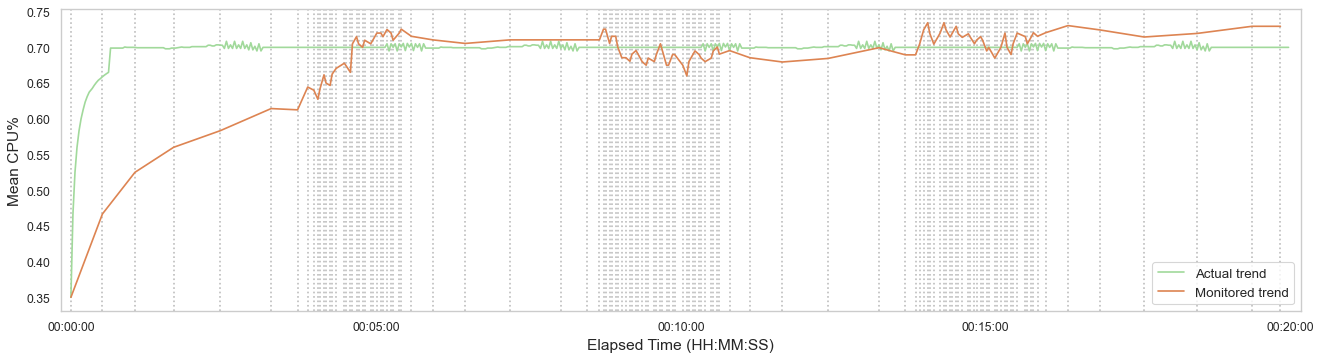

In [14]:
fig = plt.figure(figsize=(20, 5), dpi=80)

plt.plot("timedelta", "mean_free_cpu", data=df_real_ad_l, color="#a1d99b", zorder=5)
plt.plot("timedelta", "mean_free_cpu", data=df_ad_l, color=sns.color_palette()[1], zorder=10)

plt.legend(["Actual trend", "Monitored trend"], loc='lower right', prop={'size': 12})

for idx, row in df_ad_l.iterrows():
    plt.axvline(x=row["timedelta"], linestyle="dotted", color="#bdbdbd", zorder=2)

plt.xlabel("Elapsed Time (HH:MM:SS)", fontsize=14)
plt.ylabel("Mean CPU%", fontsize=14)

plt.xlim(pd.to_datetime("1970-01-01 00:00:00")-pd.to_timedelta(10, unit='s'), pd.to_datetime("1970-01-01 00:20:00")+pd.to_timedelta(10, unit='s'))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(False)

plt.savefig("graphs/exp2-stbunstb/adp_leader.pdf",bbox_inches='tight')

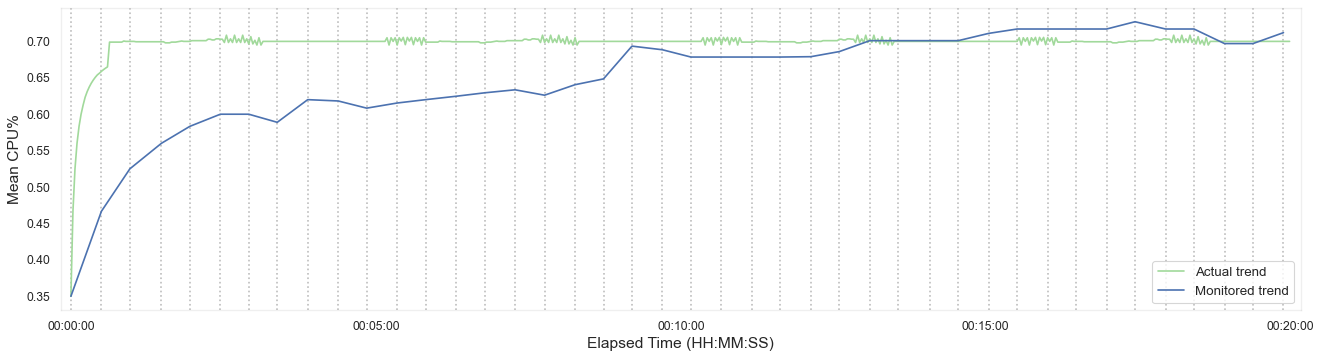

In [15]:
fig = plt.figure(figsize=(20, 5), dpi=80)

plt.plot("timedelta", "mean_free_cpu", data=df_real_nad_l, color="#a1d99b", zorder=5)
plt.plot("timedelta", "mean_free_cpu", data=df_nad_l, color=sns.color_palette()[0], zorder=10)

plt.legend(["Actual trend", "Monitored trend"], loc='lower right', prop={'size': 12})

for idx, row in df_nad_l.iterrows():
    plt.axvline(x=row["timedelta"], linestyle="dotted", color="#bdbdbd", zorder=2)

plt.xlabel("Elapsed Time (HH:MM:SS)", fontsize=14)
plt.ylabel("Mean CPU%", fontsize=14)

plt.xlim(pd.to_datetime("1970-01-01 00:00:00")-pd.to_timedelta(10, unit='s'), pd.to_datetime("1970-01-01 00:20:00")+pd.to_timedelta(10, unit='s'))

plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(False)

plt.savefig("graphs/exp2-stbunstb/nadp_leader.pdf",bbox_inches='tight')

In [16]:
# RMSE follower
s1 = 0
for i in range(len(y0s_ad_f)-1):
    s1 += (y0s_real_ad[i] - y0s_ad_f[i])**2
err_ad_follower = math.sqrt(s1/len(y0s_ad_f))

s2 = 0
for i in range(len(y0s_nad_f)-1):
    s2 += (y0s_real_nad[i] - y0s_nad_f[i])**2
err_nad_follower = math.sqrt(s2/len(y0s_nad_f))

# RMSE leader
s3 = 0
for i in range(len(y0s_ad_l)-1):
    s3 += (y0s_real_ad_l[i] - y0s_ad_l[i])**2
err_ad_leader = math.sqrt(s3/len(y0s_ad_l))

s4 = 0
for i in range(len(y0s_nad_l)-1):
    s4 += (y0s_real_nad_l[i] - y0s_nad_l[i])**2
err_nad_leader = math.sqrt(s4/len(y0s_nad_l))

print("err ad (follower): ", err_ad_follower)
print("err_nad (follower): ", err_nad_follower)
print("\n")
print("err ad (leader): ", s3)
print("err nad (leader): ", s4)

err ad (follower):  0.10796122893802967
err_nad (follower):  0.12222058971118113


err ad (leader):  5.269000674524882
err nad (leader):  6.54561649533404
